# Ordinal Simulation Example

A graph with 3 nodes 2 continous and 1 categorical variable

### Data
- simulate
- train test split

### Model Configuration
- experimentnames / paths
- Adjacency matrix 
- Neural Networks 

### Modelfit
- train model

### Fit diagnostics
- loss
- intercepts
- linear shifts
- latents
- final nll
- transformation functions
- model summary

### Sampling
- Observational
- Interventions
- Counterfactua

# Data

Setting seed: 42
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB
Train size: 80000, Validation size: 10000, Test size: 10000


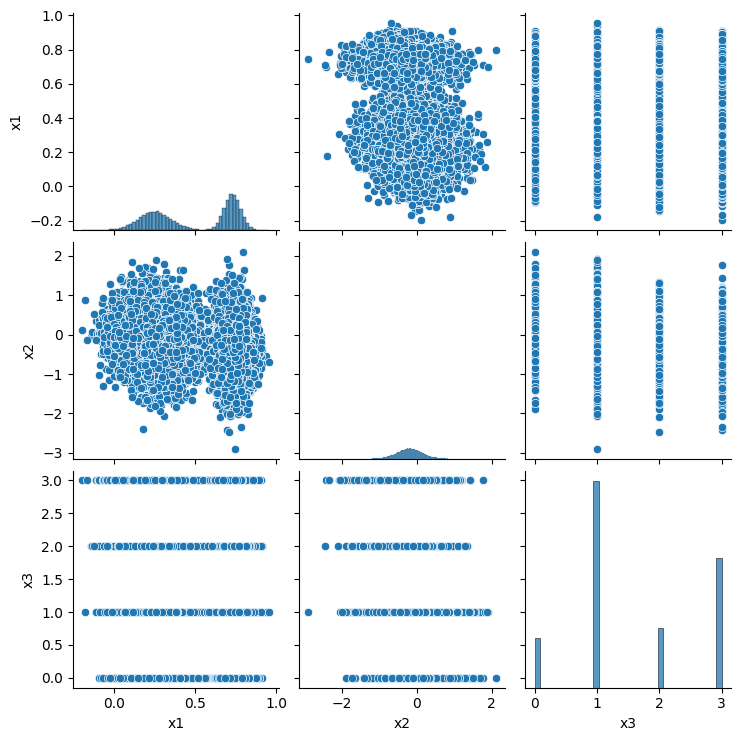

In [1]:
import os
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns

def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
        
    # x3 = x3.astype(float) / 4.0
    x3 = x3.astype(int) 
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

df = dgp(n_obs=100_000, seed=42)
df.info()
sns.pairplot(df)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

In [2]:

from tramdag import TramDagConfig

In [3]:
experiment_name = "ordinal example"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")
cfg=TramDagConfig()
cfg.setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists: /home/bule/TramDag/dev_experiment_logs/ordinal example/configuration.json


In [4]:
data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} 
cfg.set_data_type(data_type)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------------------------------------------------------
Configuration updated successfully at /home/bule/TramDag/dev_experiment_logs/ordinal example/configuration.json.


/home/bule/TramDag/tramdag/utils/configuration.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


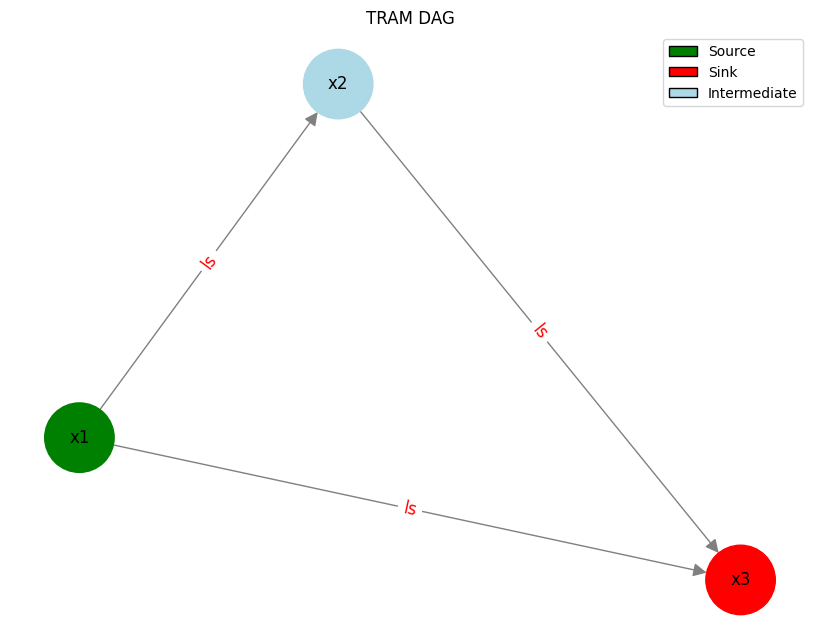

In [5]:
cfg.set_meta_adj_matrix()

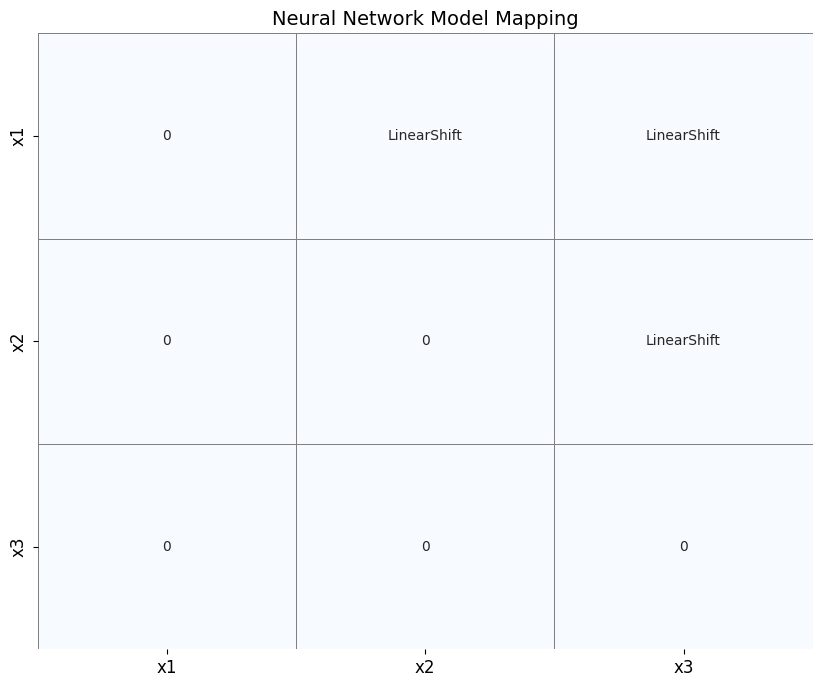

In [6]:
cfg.set_tramdag_nn_models()

In [7]:
cfg.compute_levels(train_df)

# Fit

In [8]:
from tramdag import TramDagModel
device='cpu'

In [9]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=False,device=device,initial_data = train_df) 

In [16]:
EPOCHS=200 
BATCH_SIZE=1000


td_model.fit(train_df, val_df,learning_rate=1e-2,epochs=EPOCHS,batch_size=BATCH_SIZE,device=device,num_workers=8, prefetch_factor=8,persistent_workers =True)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/ordinal example/min_max_scaling.json
[INFO] Training 3 nodes (sequential) on cpu

[INFO] Training node 'x1' for 200 epochs on cpu (pid=2925313)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'x2' for 200 epochs on cpu (pid=2925313)
[INFO] Existing model found. Loading weights and history from LAST model...

===== Epoch 10/200 =====


[INFO] Saved linear shift weights for epoch 10 -> /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 10 -> /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/simple_intercepts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 10: Train NLL=0.5559 | Val NLL=0.5486 | Time=1.30s

===== Epoch 11/200 =====
[INFO] Saved linear shift weights for epoch 11 -> /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 11 -> /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/simple_intercepts_all_epochs.json
[INFO] Saved new best model.
[INFO] Epoch 11: Train NLL=0.5470 | Val NLL=0.5423 | Time=0.85s

===== Epoch 12/200 =====
[INFO] Saved linear shift weights for epoch 12 -> /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/linear_shifts_all_epochs.json
[INFO] Saved simple intercept weights for epoch 12 -> /h

# Fit diagnostics

[INFO] Loaded training/validation histories for 3 nodes.


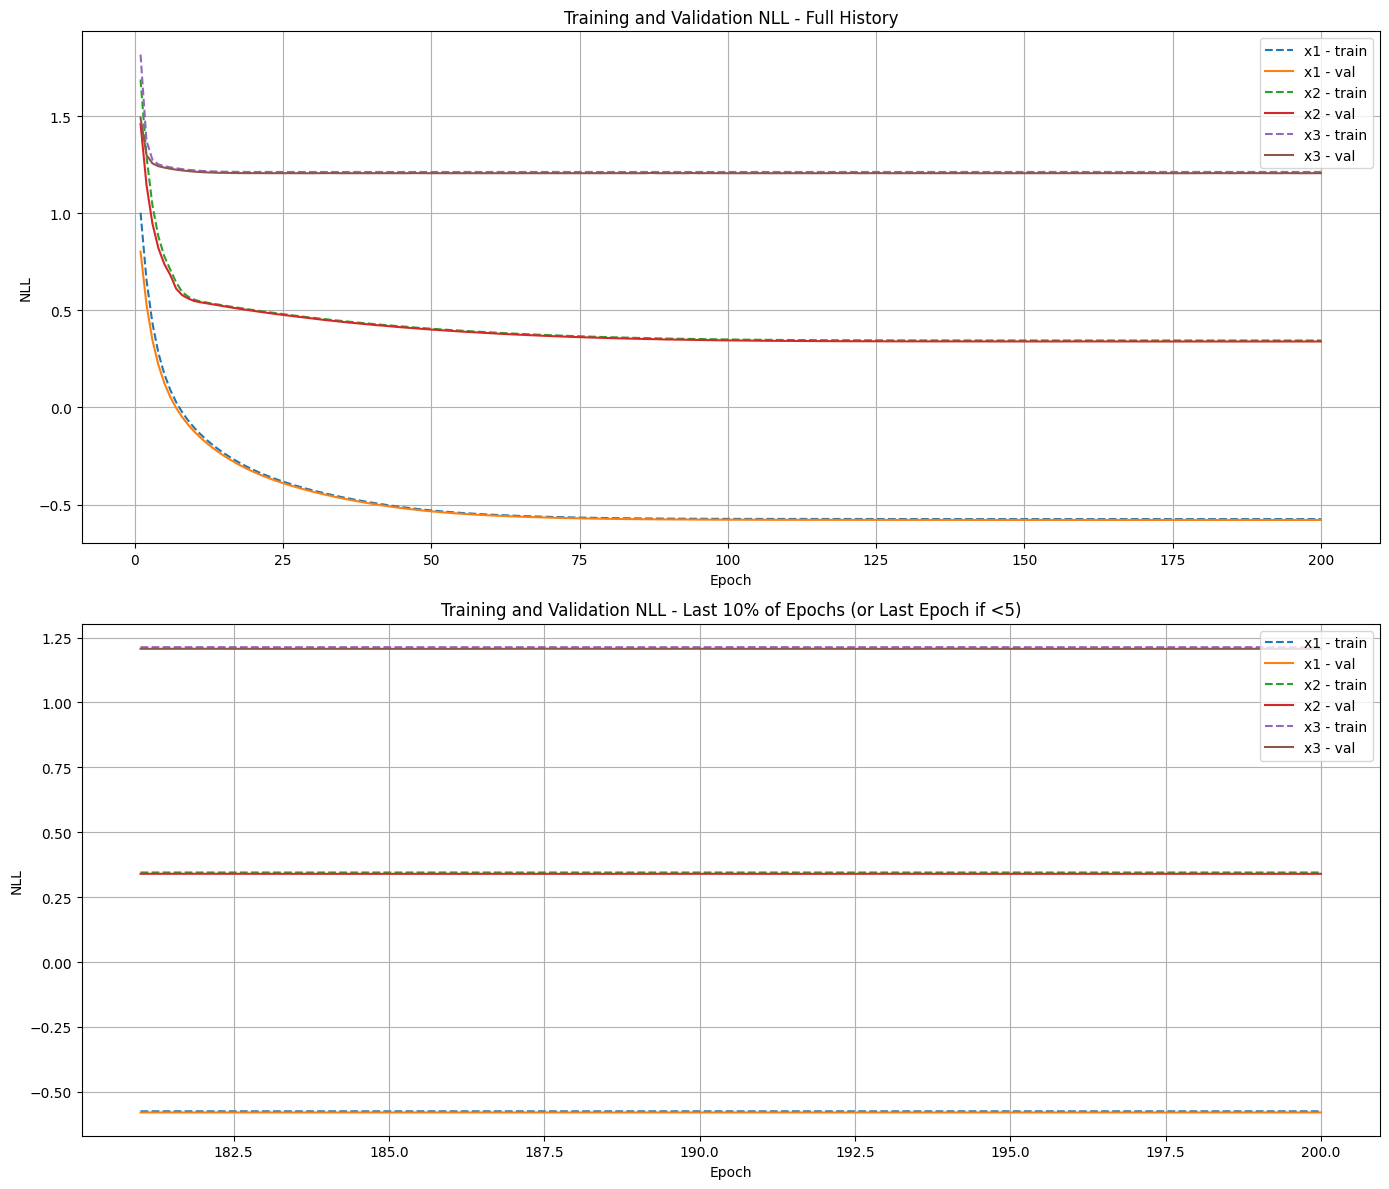

In [17]:
td_model.plot_loss_history()

```
  Continuous Outcome Logistic Regression 

Call:
Colr(formula = x2 ~ x1, data = data_6_2)

Coefficients:
      x1 
1.973891 

Log-Likelihood:
 -31293.99 (df = 8)
```
---------------------------------------------------
```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 
```

[WARNING] No linear shift history found for node 'x1' at /home/bule/TramDag/dev_experiment_logs/ordinal example/x1/linear_shifts_all_epochs.json


/home/bule/TramDag/tramdag/TramDagModel.py:927: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(flatten)


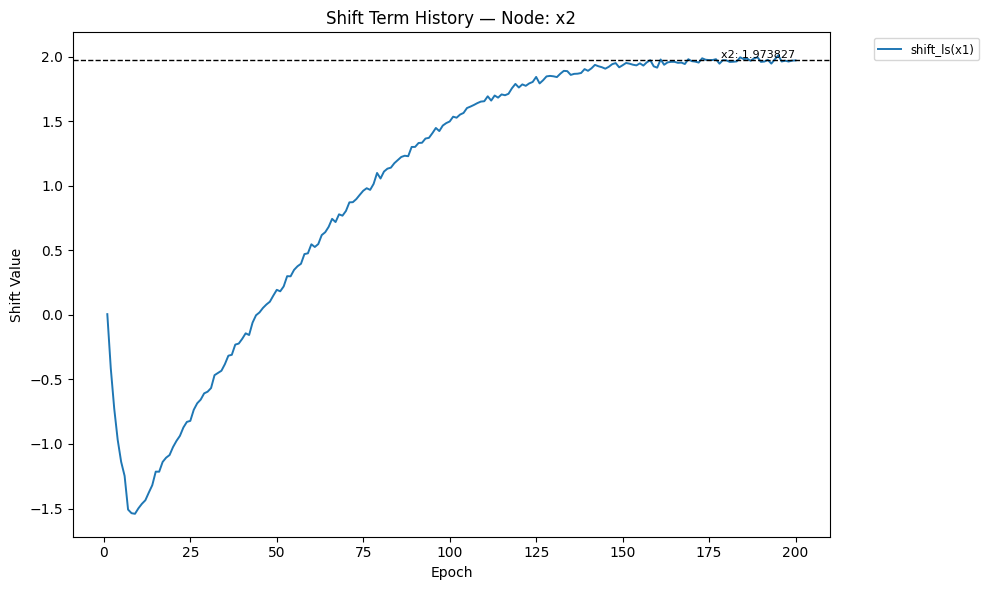

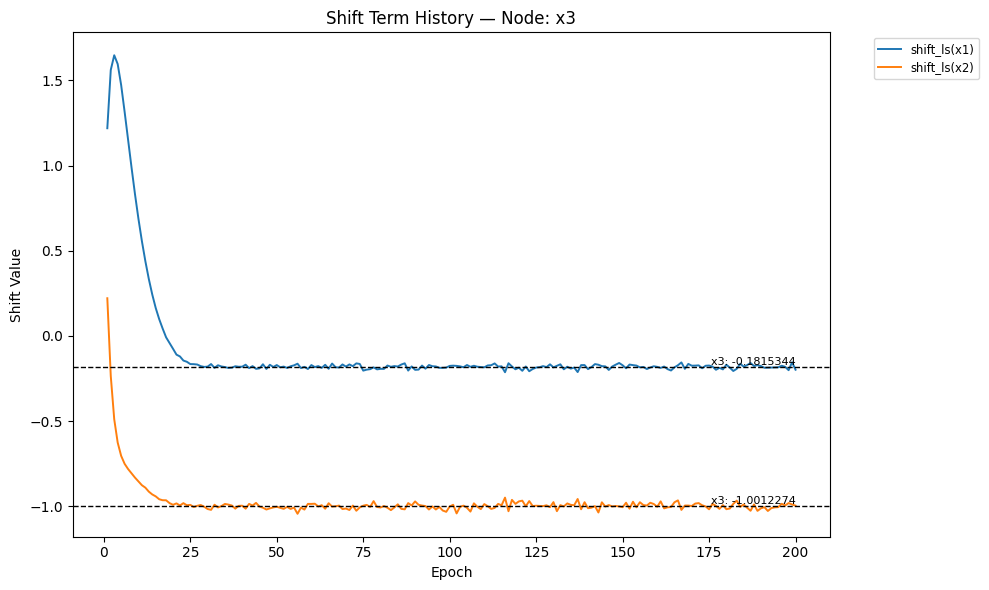

In [18]:
td_model.plot_linear_shift_history(ref_lines={'x2':[1.973827],'x3':[-0.1815344, -1.0012274 ]}) 

```
# > polr(x3_factor ~ x1 + x2, data = data_6_2)
# Call:
# polr(formula = x3_factor ~ x1 + x2, data = data_6_2)

# Coefficients:
#         x1         x2 
# -0.1815344 -1.0012274 

# Intercepts:
#       0|1       1|2       2|3 
# -1.998953  0.426397  1.032376 

# Residual Deviance: 194022.51 
# AIC: 194032.51 
```

avg NLL
194022.51 /( 2 *80_000) =  1.2126406875


/home/bule/TramDag/tramdag/TramDagModel.py:980: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


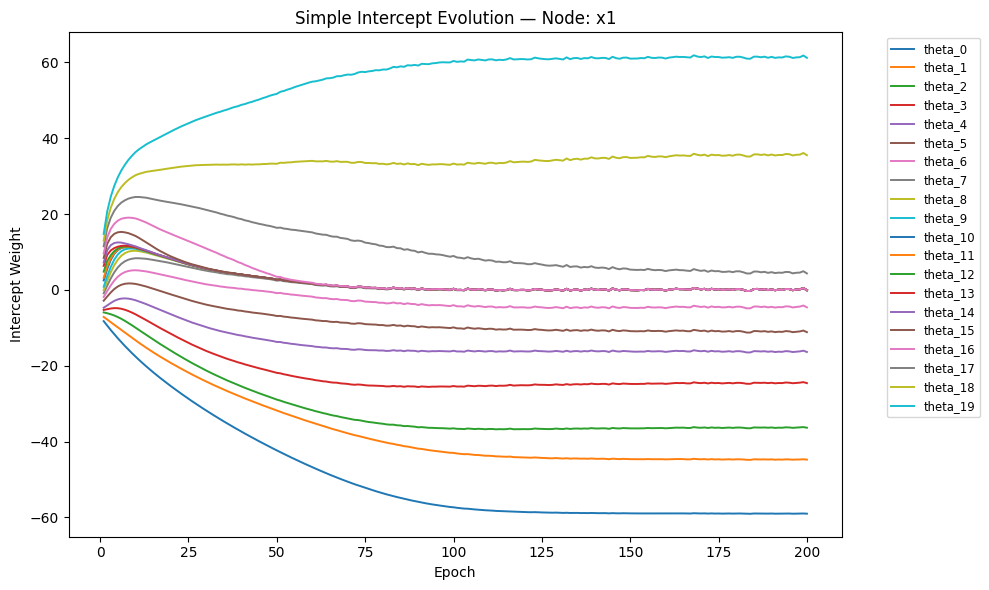

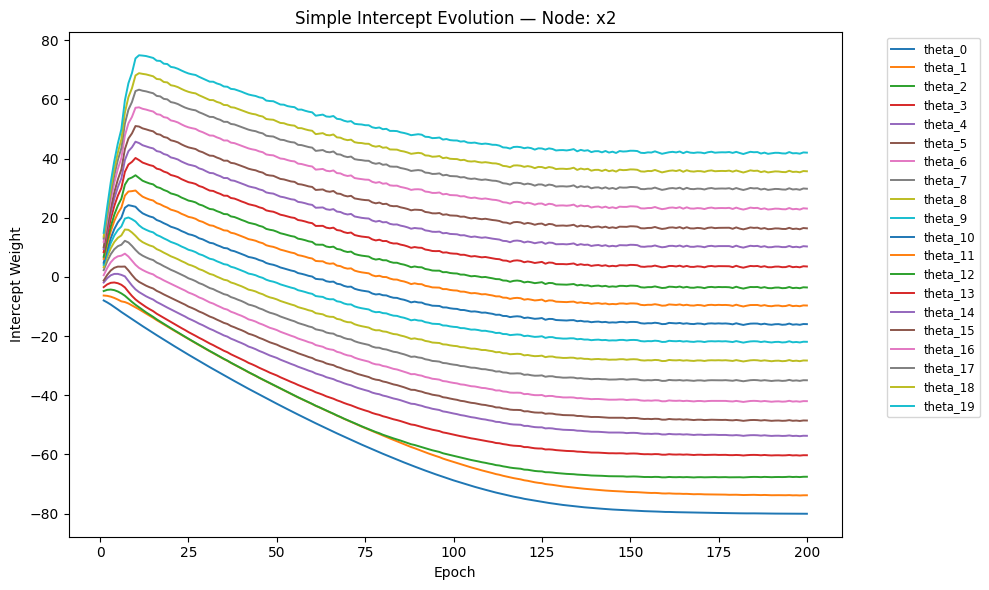

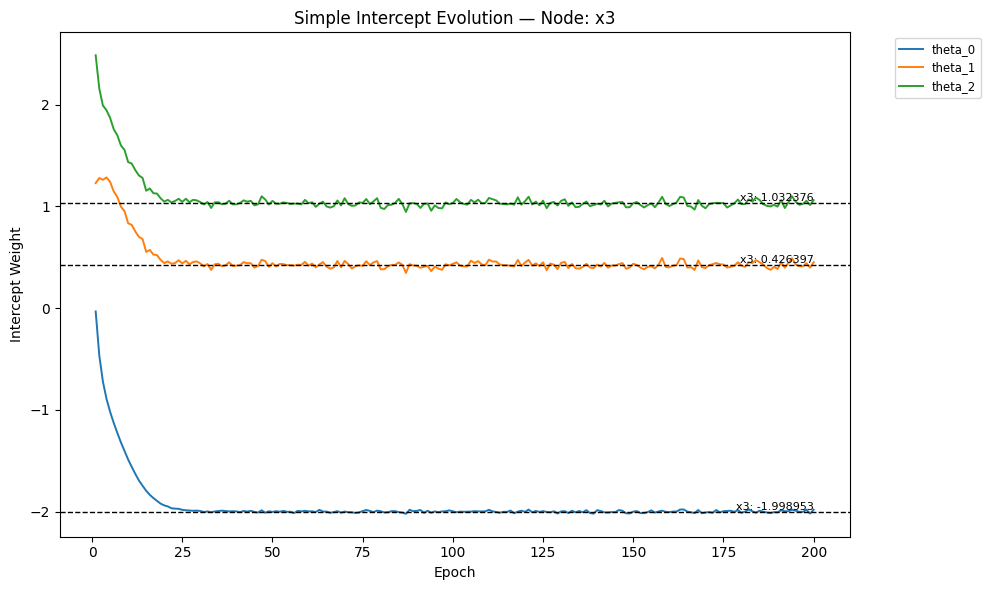

In [19]:
# [-2.054361   0.3095475  0.897935 ]

td_model.plot_simple_intercepts_history(ref_lines={'x3':[-1.998953,  0.426397,  1.032376]})

[WARNING] len(df)>1, set: plot_n_rows accordingly
x1: Simple intercept — identical h() for all samples.


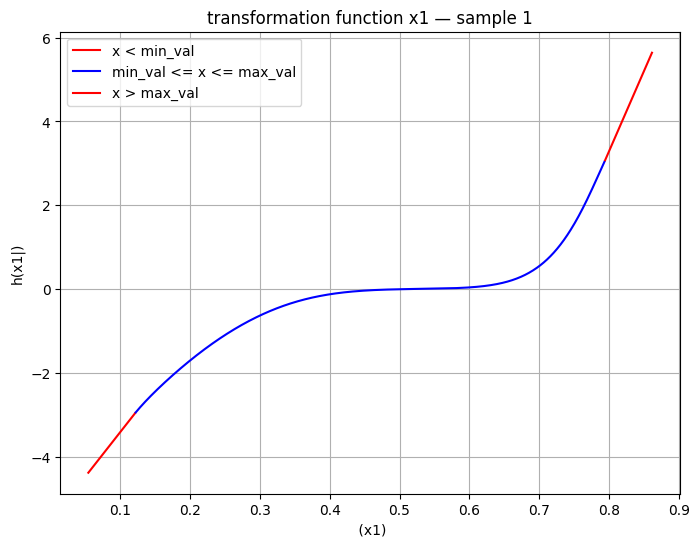


=== Sample 1/1 ===
x1    0.729475
x2   -0.573516
x3    0.000000
Name: 75220, dtype: float64


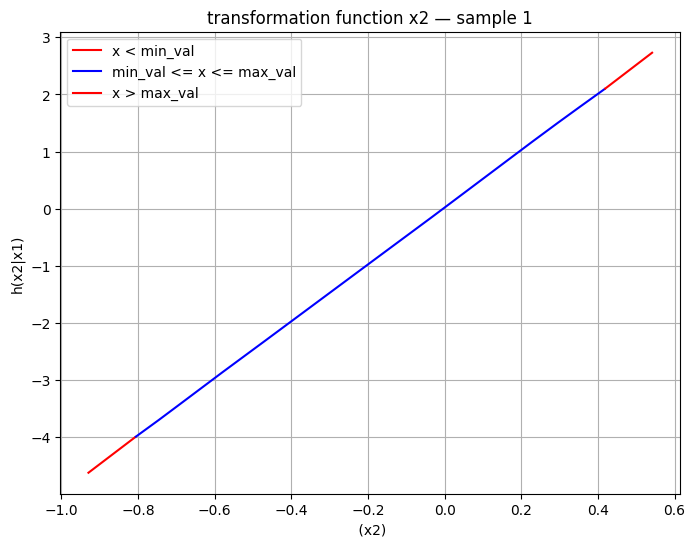

[WARNING] Node x3 is categorical, in development...

=== Sample 1/1 ===
x1    0.729475
x2   -0.573516
x3    0.000000
Name: 75220, dtype: float64


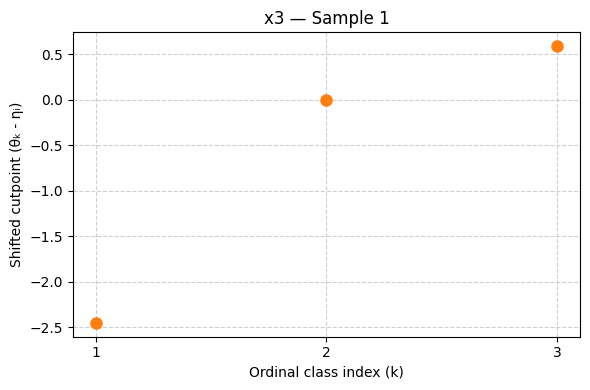

In [20]:
td_model.plot_hdag(train_df,variables=['x1','x2','x3'],plot_n_rows=1)

[INFO] Final latent DataFrame shape: (80000, 7)


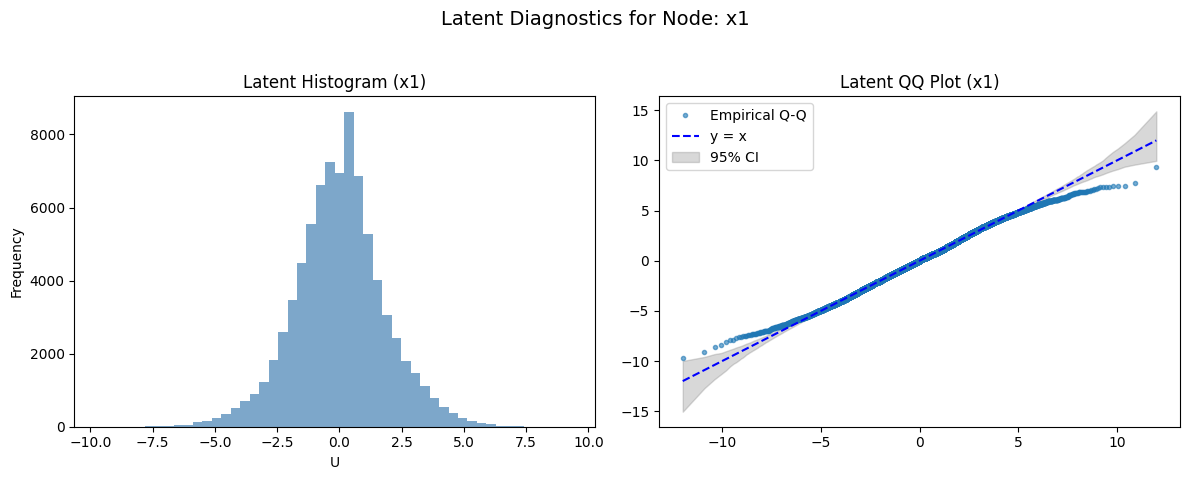

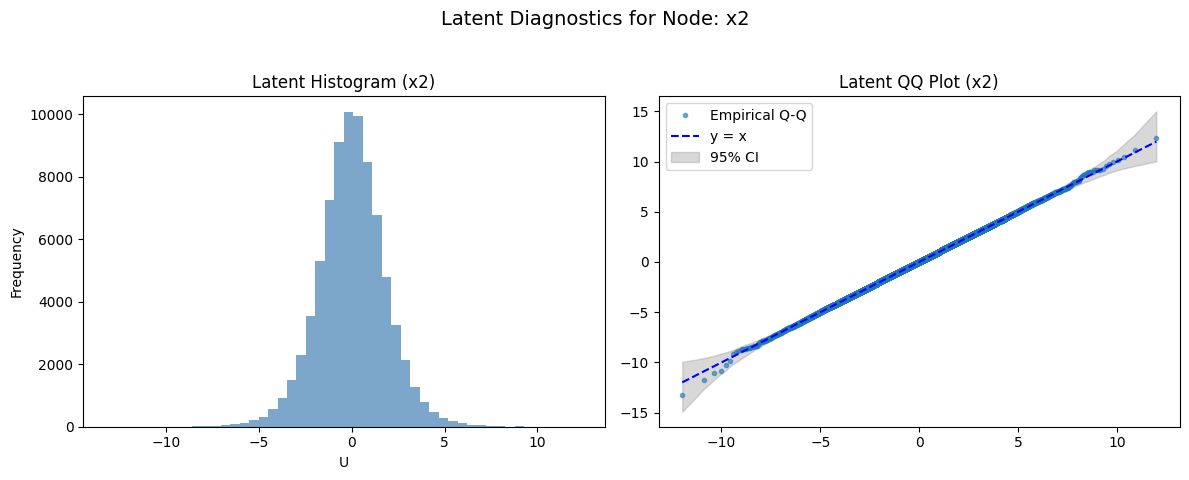

[WARNING] No latent found for node x3, skipping.


In [22]:
td_model.plot_latents(train_df)

In [21]:
td_model.nll(train_df)

{'x1': -0.5743332703908285, 'x2': 0.34419193863868713, 'x3': 1.212408224741618}

In [23]:
td_model.summary()


                                                 TRAM DAG MODEL SUMMARY                                                 

[1] TRAINING METRICS OVERVIEW
------------------------------------------------------------------------------------------------------------------------
     Node       Best Train NLL  Best Val NLL   Last Train NLL  Last Val NLL      Epochs    
      x1           -0.5747        -0.5791         -0.5747        -0.5791          200      
      x2            0.3451         0.3399          0.3451         0.3399          200      
      x3            1.2128         1.2063          1.2129         1.2065          200      
------------------------------------------------------------------------------------------------------------------------

[2] NODE-SPECIFIC DETAILS
------------------------------------------------------------------------------------------------------------------------

                                                        NODE: x1                        

# SAMPLING

## Observational

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.27it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:01<00:00, 50.06it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


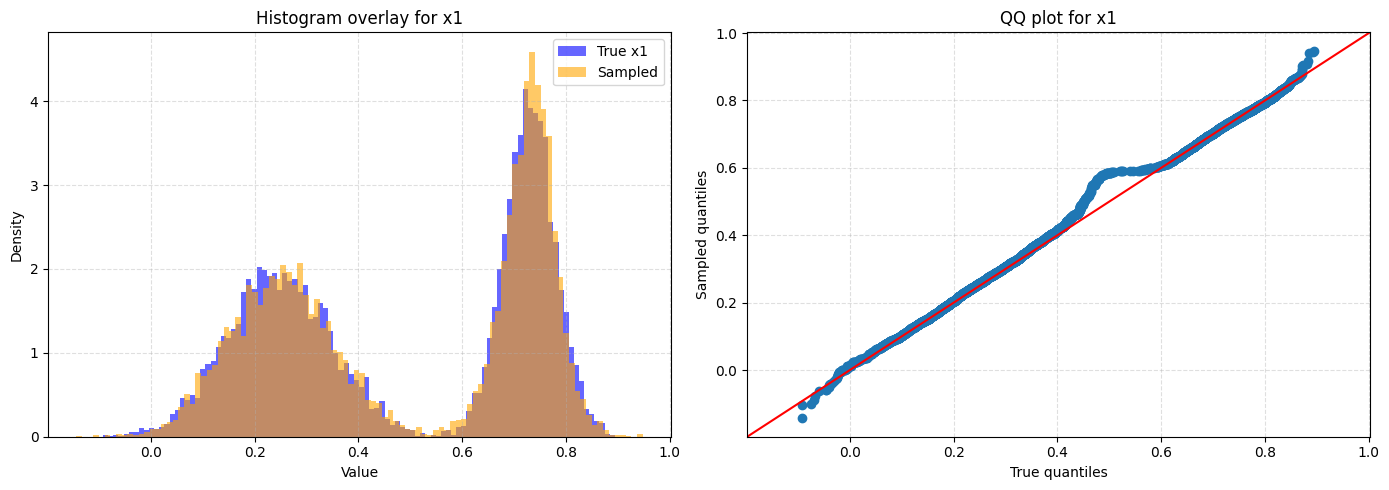

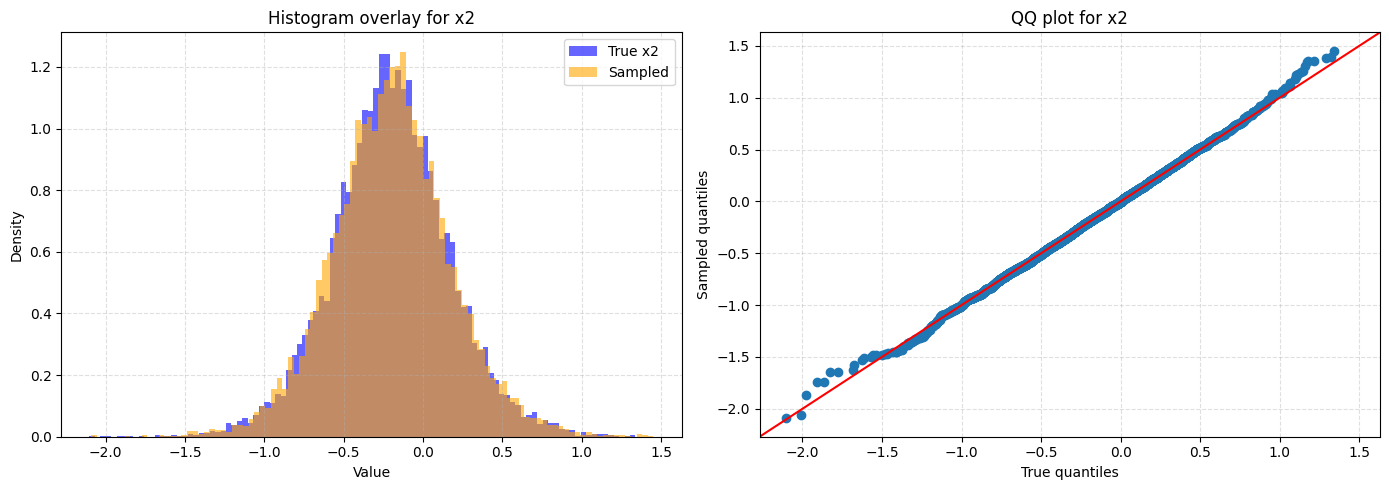

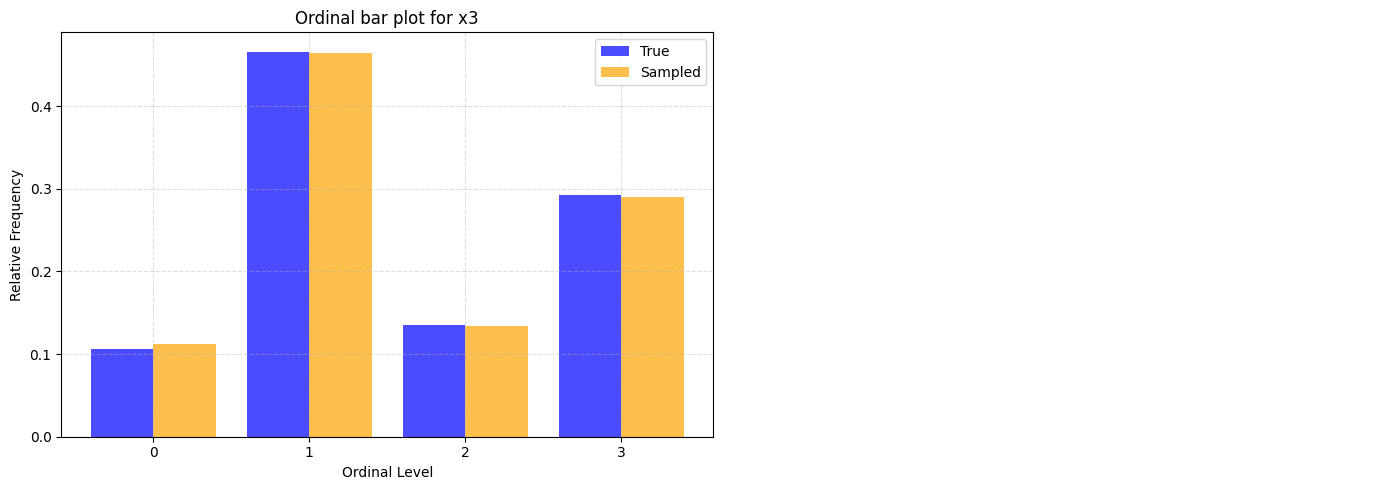

In [25]:
samples_observational, latents = td_model.sample()
td_model.plot_samples_vs_true(test_df,samples_observational)

## Interventional

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['x1']
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'x1' with value -3.0
[INFO] Interventional data for node x1 is saved

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x2 from standard logistic distribution


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 41.72it/s]

[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x3 from standard logistic distribution


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


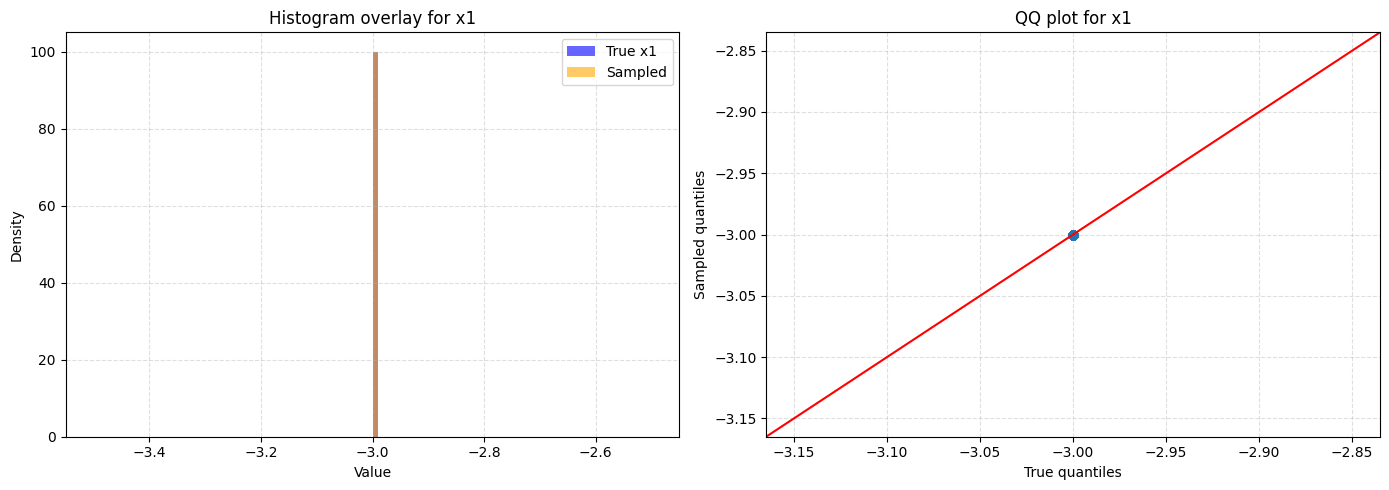

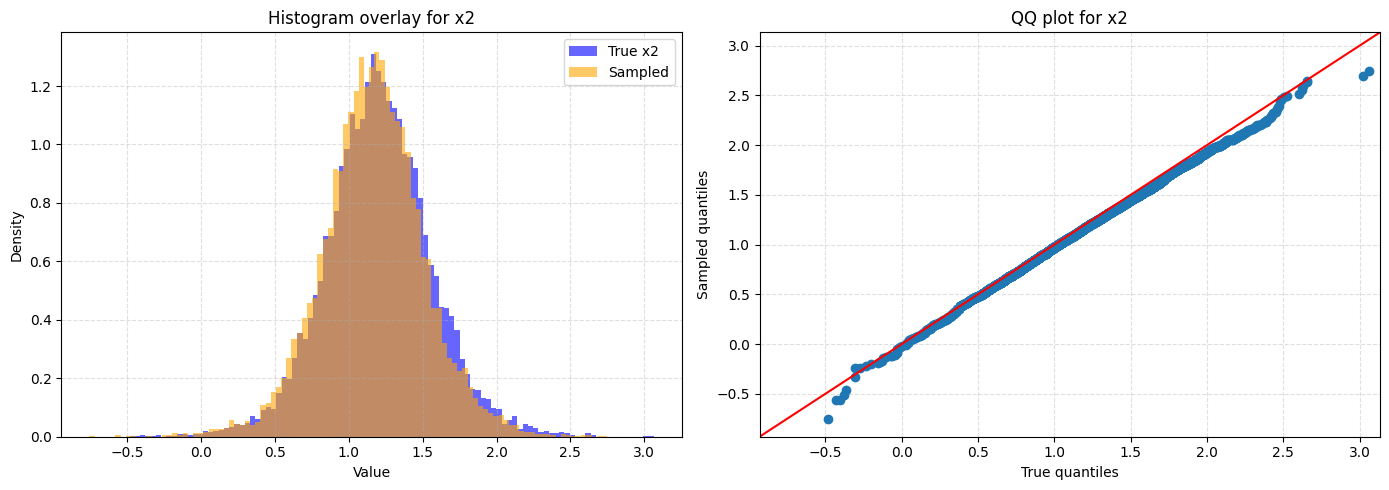

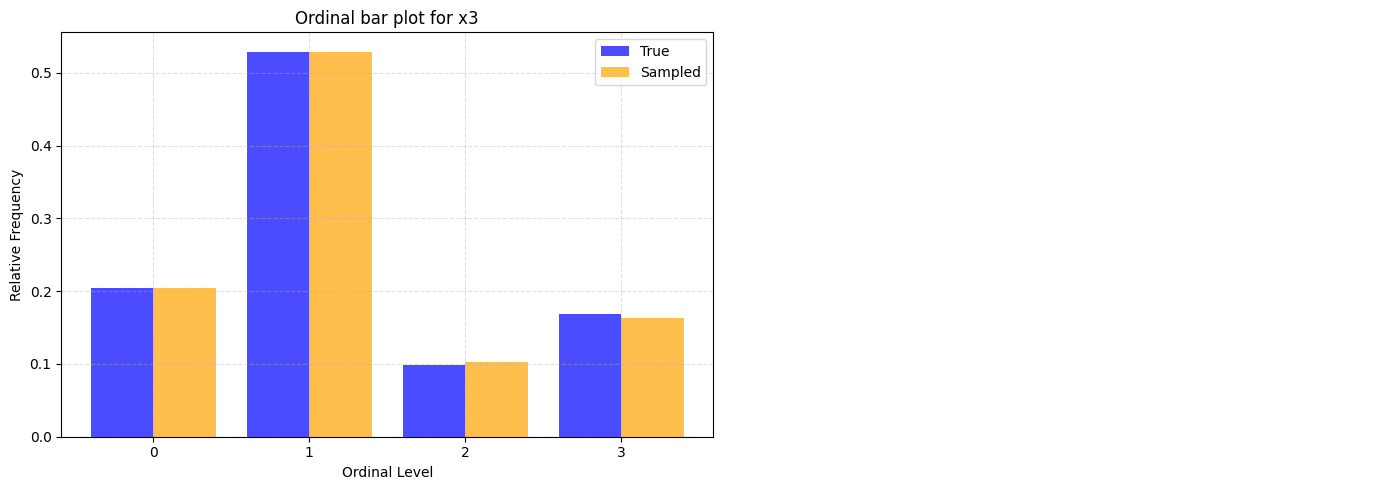

In [26]:
samples_inter, latents = td_model.sample(do_interventions={'x1':-3.0})
inter_df=dgp(n_obs=10_000, doX=[-3,None , None])
td_model.plot_samples_vs_true(inter_df,samples_inter)

## Counterfactual

### Consistency Check

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 75220 to 18502
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      100 non-null    float64
 1   x2      100 non-null    float64
 2   x3      100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


[INFO] Final latent DataFrame shape: (100, 7)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 100
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 690.75it/s]

[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x2 from dataframe column: x2_U



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 798.39it/s]


[INFO] Completed sampling for node 'x2'

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Detected 'x3_U_lower' and 'x3_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x3: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


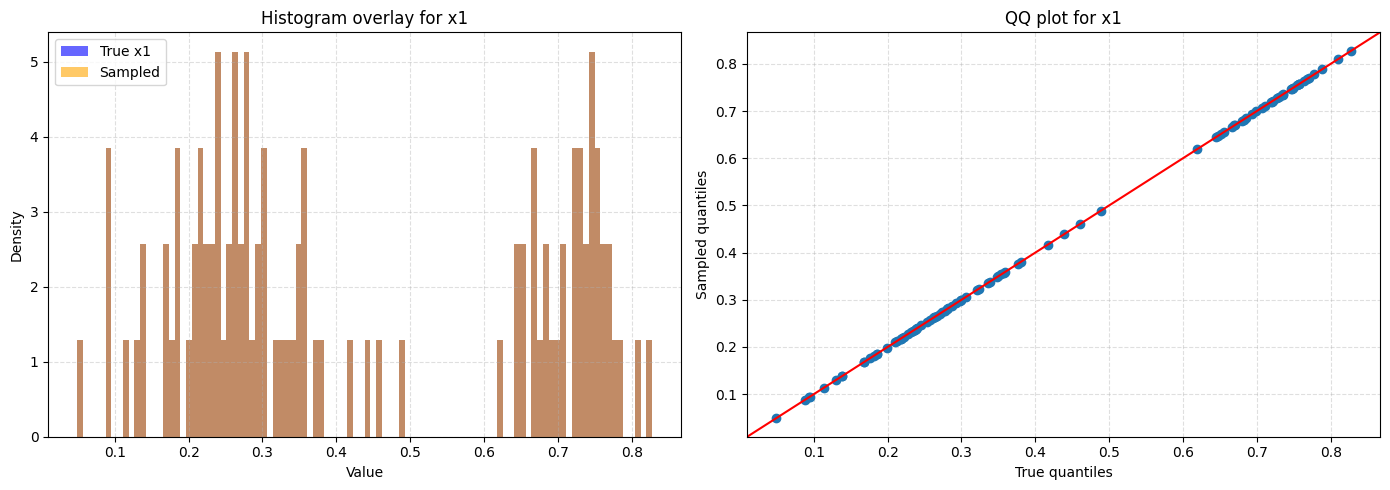

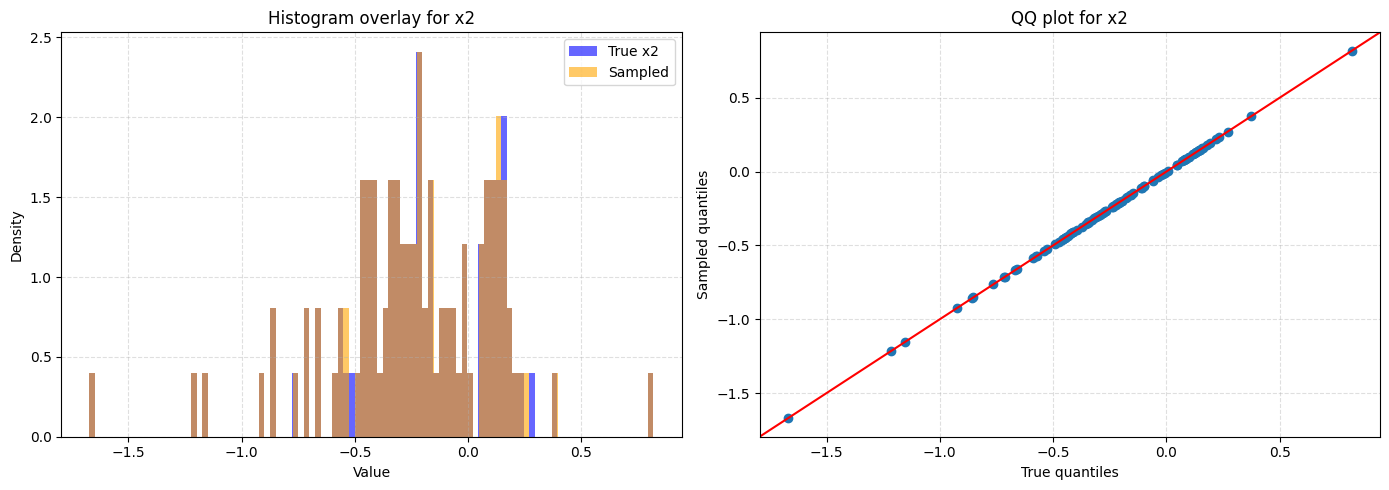

[INFO] CAUTION! x3: samples are probabilistic — each sample follows a probability distribution based on the valid latent range. Note that this frequency plot reflects only the distribution of the most probable class per sample.


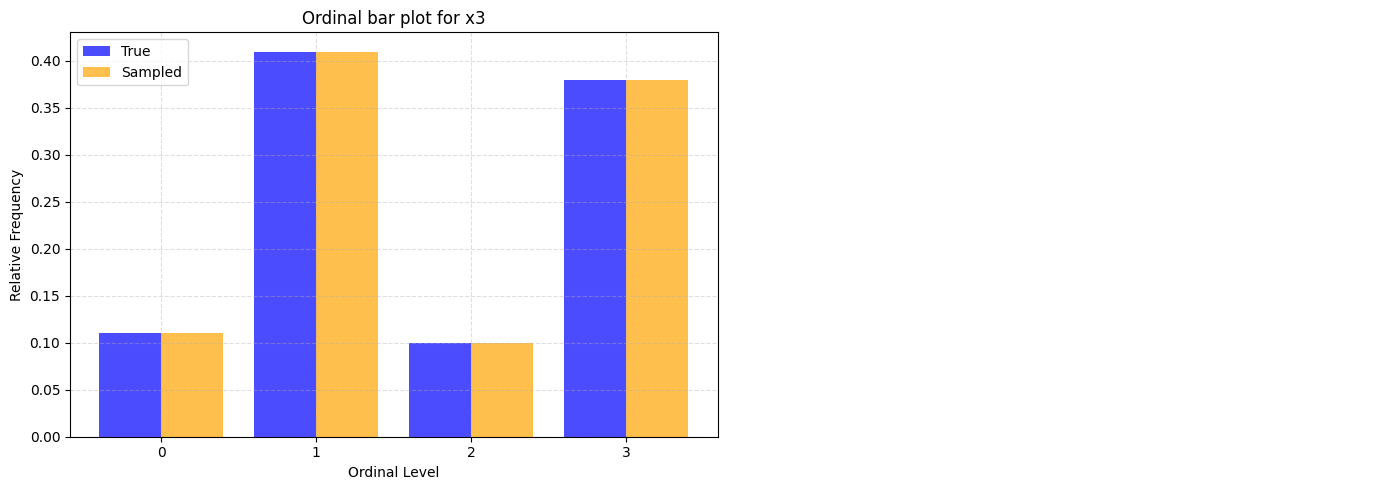

In [27]:
subset = train_df.iloc[:100]
subset =pd.DataFrame(subset)
subset.info()

u_df=td_model.get_latent(df = subset) # return of df should be x3_U_lower X3_U_upper

rsamples, latents = td_model.sample(predefined_latent_samples_df=u_df)

td_model.plot_samples_vs_true(subset,rsamples)

### Counterfactual
what would x3 have been if x2 was -0.2

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 75220 to 18502
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      100 non-null    float64
 1   x2      100 non-null    float64
 2   x3      100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 3.1 KB


[INFO] Final latent DataFrame shape: (100, 7)
[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Interventions specified for nodes: ['x2']
[INFO] Using predefined latents samples from dataframe -> therefore n_samples is set to the number of rows in the dataframe: 100
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x1/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x2/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/ordinal example/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Using predefined latents samples for node x1 from dataframe column: x1_U


[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:00<00:00, 710.33it/s]


[INFO] Completed sampling for node 'x1'

----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
[INFO] Applying intervention for node 'x2' with value -0.2
[INFO] Interventional data for node x2 is saved

----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
[INFO] Detected 'x3_U_lower' and 'x3_U_upper' — switching to counterfactual logistic sampling mode.


Sampling x3: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


[INFO] Completed sampling for node 'x3'
[INFO] DAG sampling completed successfully for all nodes.


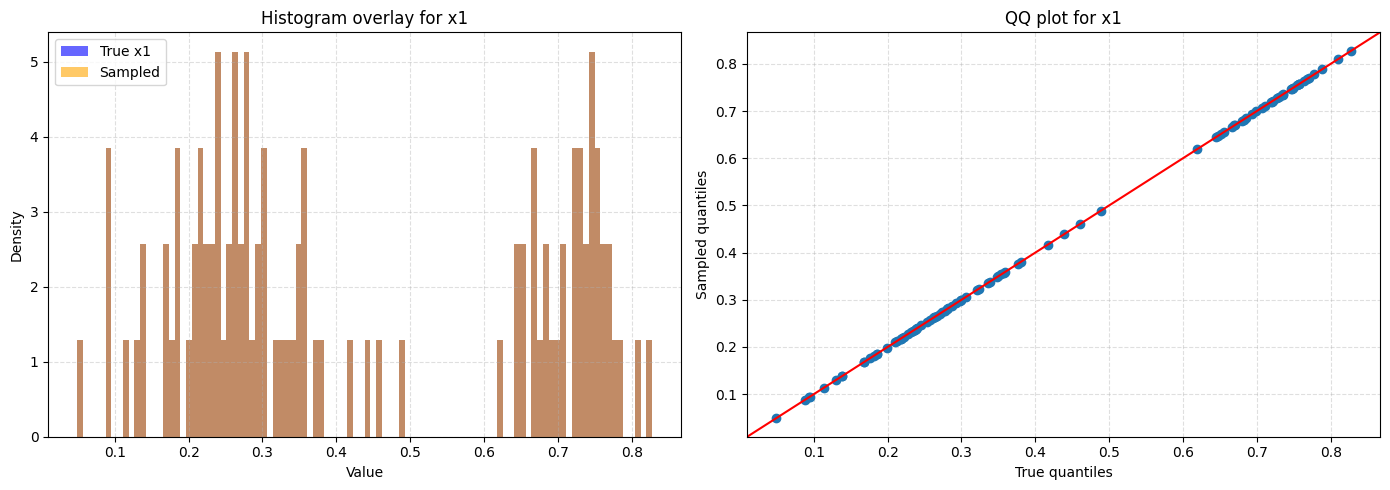

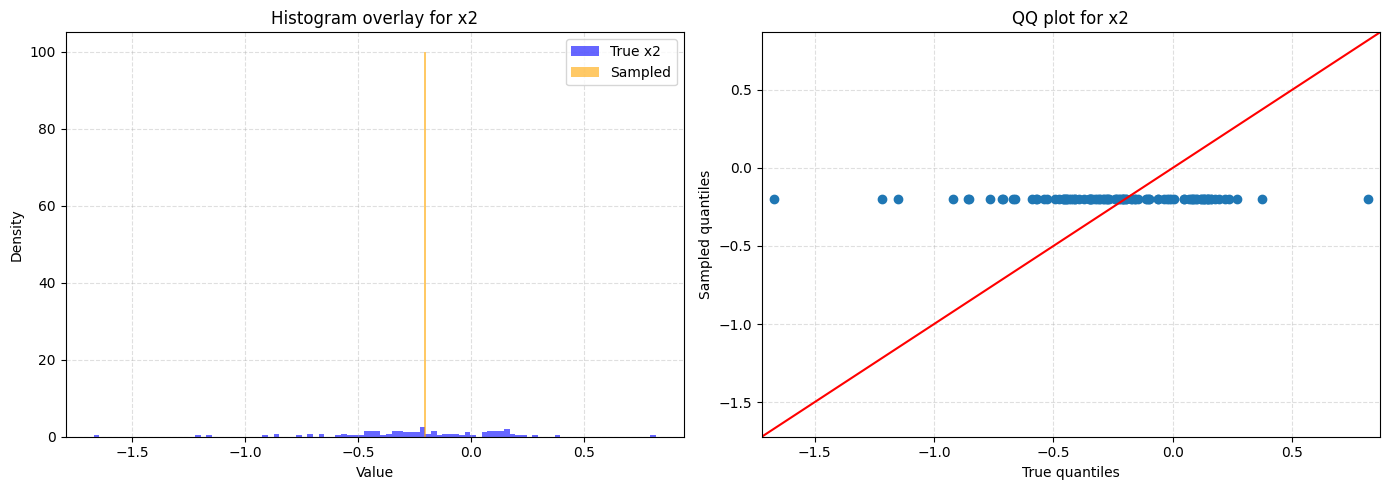

[INFO] CAUTION! x3: samples are probabilistic — each sample follows a probability distribution based on the valid latent range. Note that this frequency plot reflects only the distribution of the most probable class per sample.


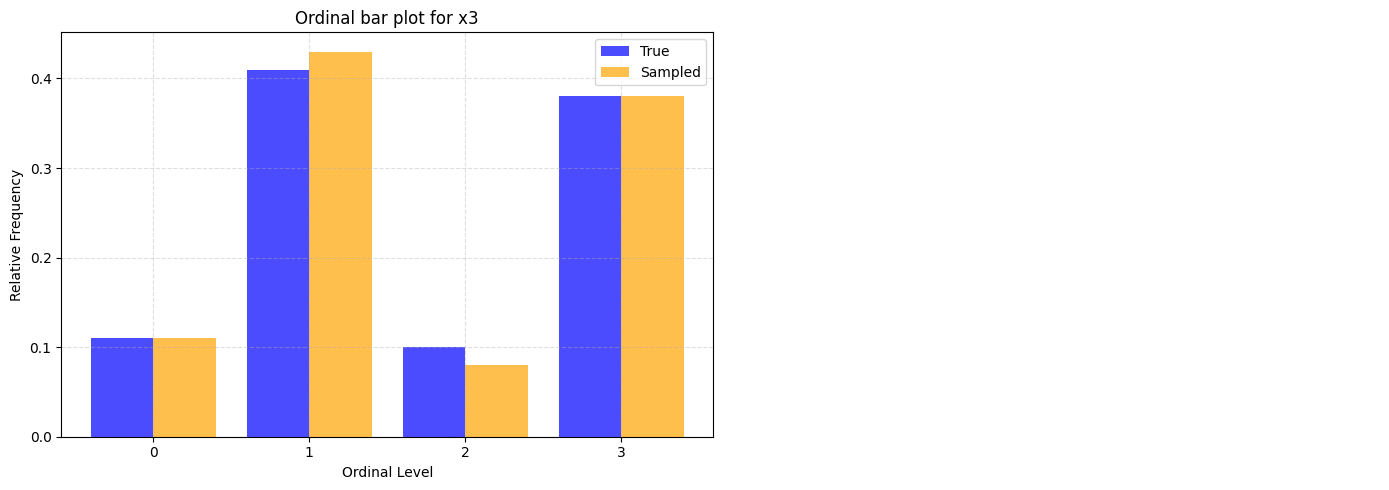

In [28]:
subset = train_df.iloc[:100]
subset =pd.DataFrame(subset)
subset.info()

u_df=td_model.get_latent(df = subset) # return of df should be x3_U_lower X3_U_upper

counterfactual, latents = td_model.sample(predefined_latent_samples_df=u_df, do_interventions={'x2':-0.2})

td_model.plot_samples_vs_true(subset,counterfactual)

In [ ]:
counterfactual

{'x1': tensor([0.7295, 0.2123, 0.2191, 0.7776, 0.3573, 0.2923, 0.0885, 0.2535, 0.2770,
         0.2179, 0.2705, 0.3807, 0.7218, 0.2805, 0.6853, 0.1683, 0.7565, 0.2573,
         0.0488, 0.7886, 0.2278, 0.7679, 0.7192, 0.2369, 0.2732, 0.1140, 0.2321,
         0.3483, 0.3539, 0.7201, 0.7542, 0.7355, 0.1299, 0.2999, 0.6793, 0.6447,
         0.7565, 0.1813, 0.3587, 0.6560, 0.7067, 0.2401, 0.6669, 0.7273, 0.3056,
         0.1861, 0.2976, 0.7492, 0.1679, 0.2101, 0.3383, 0.6695, 0.6940, 0.3764,
         0.4166, 0.2221, 0.6995, 0.3233, 0.4599, 0.3206, 0.2613, 0.2639, 0.7706,
         0.7462, 0.1378, 0.1380, 0.2823, 0.2799, 0.7471, 0.2345, 0.6470, 0.2998,
         0.6189, 0.3358, 0.2390, 0.7577, 0.0944, 0.4890, 0.2630, 0.8104, 0.7348,
         0.1988, 0.2876, 0.7109, 0.6703, 0.2179, 0.8279, 0.4392, 0.2458, 0.1852,
         0.2666, 0.3499, 0.7644, 0.1758, 0.6819, 0.7341, 0.2382, 0.6509, 0.7493,
         0.0940]),
 'x2': tensor([-0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.2000, -0.200

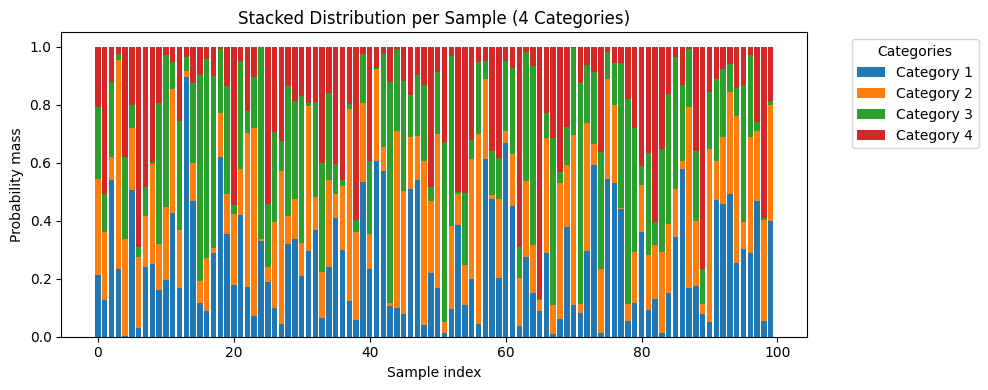

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 100 samples, each a probability distribution over 4 categories
np.random.seed(0)
data = np.random.dirichlet(np.ones(4), size=100)  # shape (100, 4)

# Plot stacked bars
fig, ax = plt.subplots(figsize=(10, 4))
bottom = np.zeros(len(data))

for i in range(4):
    ax.bar(range(len(data)), data[:, i], bottom=bottom, label=f"Category {i+1}")
    bottom += data[:, i]

plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Sample index")
plt.ylabel("Probability mass")
plt.title("Stacked Distribution per Sample (4 Categories)")
plt.tight_layout()
plt.show()


In [ ]:
td_model.summary()


                                                 TRAM DAG MODEL SUMMARY                                                 

[1] TRAINING METRICS OVERVIEW
------------------------------------------------------------------------------------------------------------------------
     Node       Best Train NLL  Best Val NLL   Last Train NLL  Last Val NLL      Epochs    
      x1           -0.5747        -0.5791         -0.5747        -0.5791          200      
      x2            0.3450         0.3399          0.3451         0.3399          200      
      x3            1.2128         1.2063          1.2129         1.2063          200      
------------------------------------------------------------------------------------------------------------------------

[2] NODE-SPECIFIC DETAILS
------------------------------------------------------------------------------------------------------------------------

                                                        NODE: x1                        